In [ ]:
# prompt: please install all the below using pip

#!pip install numpy pandas matplotlib seaborn scikit-learn tensorflow keras clean_text pandarallel


: 

In [9]:
import nltk
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.lm import Vocabulary
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, Normalizer
import joblib
from cleantext import clean
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from pandarallel import pandarallel
import ast
from imblearn.under_sampling import RandomUnderSampler
pandarallel.initialize(progress_bar=True)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

import os
IN_COLAB = False
if os.getenv("COLAB_RELEASE_TAG"):
   IN_COLAB = True

fakeNewsCorpus = None

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package punkt to /Users/suneg/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/suneg/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /Users/suneg/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [2]:
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

# Part 1

### Task 1

In [10]:
#load data
dataPath = "../data/"
if IN_COLAB:
  dataPath = "/content/drive/MyDrive/"
nsdf = pd.read_csv(dataPath + "news_sample.csv")
nsdf = nsdf.reset_index(drop=True)  # Reset index??
nsdf_raw = nsdf
print(nsdf.info())   # Check column types and missing values



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        250 non-null    int64  
 1   id                250 non-null    int64  
 2   domain            250 non-null    object 
 3   type              238 non-null    object 
 4   url               250 non-null    object 
 5   content           250 non-null    object 
 6   scraped_at        250 non-null    object 
 7   inserted_at       250 non-null    object 
 8   updated_at        250 non-null    object 
 9   title             250 non-null    object 
 10  authors           170 non-null    object 
 11  keywords          0 non-null      float64
 12  meta_keywords     250 non-null    object 
 13  meta_description  54 non-null     object 
 14  tags              27 non-null     object 
 15  summary           0 non-null      float64
dtypes: float64(2), int64(2), object(12)
memory u

In [4]:
# unique lable values
unique_values = nsdf['type'].unique()
print(unique_values)

['unreliable' 'fake' 'clickbait' 'conspiracy' 'reliable' 'bias' 'hate'
 'junksci' 'political' nan 'unknown']


In [4]:
#nan and unknown removed as they seem useless when training a classifier
nsdf = nsdf.dropna(subset=['type'])
nsdf = nsdf.loc[nsdf['type']!='unknown']
newunique_values = nsdf['type'].unique()
print(newunique_values)


['unreliable' 'fake' 'clickbait' 'conspiracy' 'reliable' 'bias' 'hate'
 'junksci' 'political']


Cleaning and Preprocessing

In [3]:
def cleanText(data, column):
    def clean_text_help(text):
        if isinstance(text, str):
            # Remove excess whitespace
            text = re.sub(r"\s+", " ", text).strip()
            #replace dates
            text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])[-/.]?(0[1-9]|1[0-2])[-/.]?([0-9]{2}|[0-9]{4})", "<DATE>", text)  # Replace date type 1
            text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])\s([A-Za-z]{3})\s([0-9]{2}|[0-9]{4})", "<DATE>", text)  # Replace date type 2
            return clean(text, lower=True, no_line_breaks=True, no_punct=True, replace_with_url="<URL>", replace_with_email="<EMAIL>", replace_with_number="<NUM>", replace_with_digit="<NUM>")
        return text  # Return unchanged if not a string
    data[column] = data[column].parallel_apply(clean_text_help)  # Apply function
    return data

In [7]:
#Tokenize the text function
def tokenizeText(data, column):
    def tokenize_text_help(text):
        if isinstance(text, str):
            return word_tokenize(text)
        return text  # Return unchanged if not a string
    data[column] = data[column].parallel_apply(tokenize_text_help)  # Apply function
    return data

In [8]:
#function for removeing stopwords
def remove_stopwords(data, column):
    def remove_stopwords_help(text):
        stop_words = set(stopwords.words('english'))  # Load stopwords
        if isinstance(text, str):
            return [word for word in text.at[0, 'content'] if not word.lower() in stop_words]
        return text  # Return unchanged if not a string
    data[column] = data[column].parallel_apply(remove_stopwords_help)  # Apply function
    return data

In [9]:
#funtion for populating vocabulary
def populate_vocabulary(data):
    N = data.shape[0]  # Get the number of rows
    allWords = []
    for i in range(N):
        if isinstance(data.at[i, 'content'], str):  # Ensure it's a string
            allWords.append(data.at[i, 'content'])
    return Vocabulary(allWords, unk_cutoff=2)

#langsom kørertid men kunne ikke finde ud af det med apply. Nogne med en god ide??
# Can just use value_vounts()


In [6]:
#making frequency dictionary
def getFrequency(data, column, preTokenized):
    N = data.shape[0]  # Get the number of rows
    allWords = []
    if preTokenized != 1 and preTokenized != 0:
        return "Wrong preTokenize input"
    if preTokenized == 1:
        for text in data[column]:
            if isinstance(text, list):  # Ensure text is already tokenized (list of words)
                allWords.extend(text)
            elif isinstance(text, str):  # If still a string, split it as a fallback
                allWords.extend(text.split())
    elif preTokenized == 0:
        for text in data[column]:
            if isinstance(text, str):
                allWords.extend(word_tokenize(text))

    return FreqDist(allWords)

#Alternative? Returns a pandas series, with word and frequency, very fast.
def getFreq(data, column):
    return data[column].str.split().explode().value_counts()

In [7]:
#function for removeing stopwords
def dataStemming(data, column):
    ps = PorterStemmer()
    def dataStemming_help(text):
        if isinstance(text, str):
            return ps.stem(text)
        return text  # Return unchanged if not a string
    data[column] = data[column].parallel_apply(dataStemming_help)  # Apply function
    return data

In [ ]:
# One big function to process data:
def processData(data, column):
    def apply_sequential_helper(functions):
        # assume type siganture of functions to be List[f : String -> string ]
        def inner(text):
            for f in functions:
                text = f(text)
            return text
        return inner

    def clean_text_help(text):
        if isinstance(text, str):
            # Remove excess whitespace
            text = re.sub(r"\s+", " ", text).strip()
            #replace dates
            text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])[-/.]?(0[1-9]|1[0-2])[-/.]?([0-9]{2}|[0-9]{4})", "<DATE>", text)  # Replace date type 1
            text = re.sub(r"(0[1-9]|[1-2][0-9]|3[0-1])\s([A-Za-z]{3})\s([0-9]{2}|[0-9]{4})", "<DATE>", text)  # Replace date type 2
            return clean(text, lower=True, no_line_breaks=True, no_numbers=True, no_emails=True, no_urls=True, no_punct=True, replace_with_url=r"__URL__", replace_with_email=r"__EMAIL__", replace_with_number=r"__NUM__", replace_with_digit=r"__NUM__")
        raise TypeError("Clean_text passed non-string")

    def tokenize_text_help(text):
        if isinstance(text, str):
            return pd.Series(word_tokenize(text))
        return text  # Return unchanged if not a string

    def remove_stopwords_help(text):
      # text is a Series[str]
        stop_words = set(stopwords.words('english'))  # Load stopwords
        #if isinstance(text, str):
        #    return [word for word in text.at[0, 'content'] if not word.lower() in stop_words]
        #return text  # Return unchanged if not a string
        return text[~text.isin(stop_words)]

    ps = PorterStemmer()
    def dataStemming_help(text):
        #if isinstance(text, str):
        #    return ps.stem(text)
        #return text  # Return unchanged if not a string
        if(isinstance(text, str)):
            return pd.Series(ps.stem(text))
        return text.apply(ps.stem)

    def type_cleaner(text):
        if isinstance(text, str):
            return pd.Series(text).to_list()
        return text.to_list()

    data[column] = data[column].parallel_apply(apply_sequential_helper(
        [clean_text_help, # str -> str
        tokenize_text_help, # str -> list[str]
        remove_stopwords_help, #series[str] -> series[str]
        dataStemming_help, #series[str] -> series[str]
        type_cleaner # series[str] -> series[str]
    ]))
    return data

In [5]:
"""
nsdf_cleaned = cleanText(nsdf, 'content')
nsdf_tokenized = tokenizeText(nsdf_cleaned, 'content')                  #tokenizing
nsdf_cleaned_tokenized_nostopwords = remove_stopwords(nsdf_tokenized, 'content')           #removing stopwords
nsdf_preprocessed = dataStemming(nsdf_cleaned_tokenized_nostopwords, 'content')
"""
nsdf_processed = processData(nsdf, 'content')
nsdf_processed.dropna(subset=['content'], inplace=True)  # Drop rows with no content
nsdf_processed.reset_index(drop=True, inplace=True)  # Reset index
print(nsdf_processed.at[0, 'content'])

['sometim', 'power', 'christma', 'make', 'wild', 'wonder', 'thing', 'need', 'believ', 'holi', 'triniti', 'believ', 'posit', 'power', 'good', 'other', 'simpl', 'act', 'give', 'without', 'receiv', 'lost', 'mani', 'us', 'day', 'worri', 'money', 'success', 'hold', 'us', 'back', 'give', 'other', 'need', 'one', 'congreg', 'ohio', 'move', 'action', 'power', 'sermon', 'given', 'church', 'christma', 'eve', 'pastor', 'grand', 'lake', 'unit', 'methodist', 'church', 'celina', 'ohio', 'gave', 'emot', 'sermon', 'import', 'understand', 'messag', 'jesu', 'mani', 'religi', 'peopl', 'messag', 'jesu', 'help', 'other', 'make', 'sure', 'peopl', 'suffer', 'get', 'help', 'need', 'enjoy', 'life', 'littl', 'bit', 'sermon', 'realli', 'generos', 'look', 'like', 'live', 'jesu', 'live', 'long', 'time', 'ago', 'act', 'gener', 'fashion', 'time', 'would', 'gener', 'act', 'look', 'like', 'time', 'focu', 'sermon', 'potenc', 'sermon', 'lost', 'congreg', 'move', 'take', 'action', 'sermon', 'end', 'congreg', 'decid', 'tak

In [10]:
#word frequency pre preprocessing
print("word frequency pre preprocessing")
word_frequency_pre = getFreq(nsdf_raw, 'content').sum()
print(word_frequency_pre)

word frequency pre preprocessing
170462


In [11]:
#word frequency post preprocessing
print("word frequency post preprocessing")
# getfreq assumes different type signature, so we have to do it this way
word_frequency_post = nsdf_processed["content"].explode().value_counts().sum()
print(word_frequency_post)

word frequency post preprocessing
86067


In [19]:
#word frequency post stemming
#print("word frequency post stemming")
#word_frequency_postStem = getFrequency(nsdf_.processed, 'content', 1)
#print(sum(word_frequency_postStem.values()))

In [20]:
#pre = word_frequency_pre
#post = word_frequency_post
#print("Reduction rate of the vocabulary size after removing stopwords:")
#print(abs(pre -post))
#print("Further  reduction rate of the vocabulary size after stemming")
#postStem = sum(word_frequency_post.values())
#print(abs(post -postStem))

### Task 2

In [ ]:
#load data
fakeNewsCorpus = pd.read_csv(dataPath + "995,000_rows.csv")
#Hva saten er den der unnamed???
print(fakeNewsCorpus.head())
#fakeNewsCorpus['content'].duplicated()
news_noDup = fakeNewsCorpus.drop_duplicates(subset=['content']).dropna(subset=['content']).reset_index(drop=True)

  Unnamed: 0         id               domain        type  \
0        732  7444726.0   nationalreview.com   political   
1       1348  6213642.0    beforeitsnews.com        fake   
2       7119  3867639.0     dailycurrant.com      satire   
3       1518  9560791.0          nytimes.com    reliable   
4       9345  2059625.0  infiniteunknown.net  conspiracy   

                                                 url  \
0  http://www.nationalreview.com/node/152734/%E2%...   
1  http://beforeitsnews.com/economy/2012/06/the-c...   
2  http://dailycurrant.com/2016/01/18/man-awoken-...   
3  https://query.nytimes.com/gst/fullpage.html?re...   
4  http://www.infiniteunknown.net/2011/09/14/100-...   

                                             content  \
0  Plus one article on Google Plus\n\n(Thanks to ...   
1  The Cost Of The Best Senate Banking Committee ...   
2  Man Awoken From 27-Year Coma Commits Suicide A...   
3  WHEN Julia Geist was asked to draw a picture o...   
4  – 100 Compiled Stud

In [1]:
#Cleaning
news_processed = processData(news_noDup, 'content')
news_processed.to_json(dataPath + "news_processed.json", orient='records', lines=True)

NameError: name 'processData' is not defined

### Task 3

In [11]:
if fakeNewsCorpus is None:
    json_reader = pd.read_json(dataPath + "news_processed.json", orient='records', lines=True, chunksize=1500)
    fakeNewsCorpus = pd.concat(json_reader, ignore_index=True)
# timed: 12 min på M1 macbook chunk=1000
print(fakeNewsCorpus.info())   # Check column types and missing values
#fndf = fakeNewsCorpus.reset_index(drop=True)  # Reset index
fndf = fakeNewsCorpus


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812912 entries, 0 to 812911
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Unnamed: 0        812911 non-null  float64       
 1   id                812912 non-null  object        
 2   domain            812912 non-null  object        
 3   type              770599 non-null  object        
 4   url               812912 non-null  object        
 5   content           812912 non-null  object        
 6   scraped_at        812911 non-null  object        
 7   inserted_at       812911 non-null  datetime64[ns]
 8   updated_at        812911 non-null  datetime64[ns]
 9   title             812735 non-null  object        
 10  authors           502785 non-null  object        
 11  keywords          0 non-null       float64       
 12  meta_keywords     775004 non-null  object        
 13  meta_description  421991 non-null  object        
 14  tags

: 

### Cleaning and Preprocessing

In [5]:
print("Pandas DataFrame:")
display(fndf.iloc[0])



Pandas DataFrame:


Unnamed: 0                                                      732.0
id                                                            7444726
domain                                             nationalreview.com
type                                                        political
url                 http://www.nationalreview.com/node/152734/%E2%...
content             [plu, one, articl, googl, plu, thank, ali, alf...
scraped_at                                 2017-11-27T01:14:42.983556
inserted_at                                2018-02-08 19:18:34.468038
updated_at                                 2018-02-08 19:18:34.468066
title                                              Iran News Round Up
authors                                                          None
keywords                                                          NaN
meta_keywords       ['National Review', 'National Review Online', ...
meta_description                                                 None
tags                

## Observations about dataset

In [12]:
unique_values = fndf['type'].unique()
print(unique_values)
#hard to know how to classify nan and unknown, so removed for now
# we also remove the a weird type 
fndf = fndf.dropna(subset=['type'])
fndf = fndf.loc[(fndf['type']!='unknown') & (fndf['type']!='unreliable') & (fndf['type'] != '2018-02-10 13:43:39.521661')]
# Need to reset index

newunique_values = fndf['type'].unique()
print(newunique_values)


['political' 'fake' 'satire' 'reliable' 'conspiracy' 'unreliable' 'bias'
 'rumor' 'unknown' None 'clickbait' 'hate' 'junksci'
 '2018-02-10 13:43:39.521661']
['political' 'fake' 'satire' 'reliable' 'conspiracy' 'bias' 'rumor'
 'clickbait' 'hate' 'junksci']


In [13]:

# groups (reliable) as truenews 1 and (all others) in fakenews 0
    #note this is naive and should be reconsidered later

# reliable, clickbait and political are all, by their contents, factually correct (albeit possibly politcally motivated)
# we deem those to be "real" news
print("adding binary labels")
fndf['type'] = fndf['type'].replace(r'^(reliable|clickbait|political)$', '1', regex=True) 
fndf['type'] = fndf['type'].replace(r'^(?!1$).+', '0', regex=True)   # Replace everything except '1' with '0'
#fndf['type'] = fndf['type'].fillna('0')

newunique_values = fndf['type'].unique()
print(newunique_values)
fndf.shape[0]
fndf['type'] = fndf['type'].astype(int)  # Convert to integer

print(("real vs fake:"))
print(fndf['type'].value_counts())

adding binary labels
['1' '0']
real vs fake:
type
1    378763
0    344969
Name: count, dtype: int64


In [14]:
relib_news = fndf.loc[fndf['type'] == 1]
fake_news = fndf.loc[fndf['type'] == 0]

print(relib_news.shape[0], " : ", fake_news.shape[0])

print("distribution for real news")
#print(relib_news["content"].explode().value_counts())
real_dist = FreqDist(relib_news["content"].explode())
print(real_dist.most_common(200))

print("distribution for fake news")
#print(fake_news["content"].explode().value_counts())
fake_dist = FreqDist(fake_news["content"].explode())
print(fake_dist.most_common(200))

print("distribution for all news")
#print(fndf["content"].explode().value_counts())
all_dist = FreqDist(fndf["content"].explode())
print(all_dist.most_common(200))

378763  :  391836
distribution for real news
[('num', 3158753), ('said', 901336), ('new', 583966), ('one', 512685), ('mr', 509038), ('would', 463907), ('year', 447673), ('time', 447646), ('$', 446510), ('like', 408097), ('state', 407964), ('peopl', 389604), ('us', 306603), ('also', 301689), ('continu', 299197), ('stori', 294520), ('say', 294174), ('york', 281663), ('make', 279645), ('read', 279093), ('work', 273287), ('get', 271541), ('go', 265306), ('presid', 252996), ('even', 247347), ('first', 246291), ('two', 240050), ('use', 237233), ('numnum', 231782), ('last', 231383), ('pleas', 230664), ('trump', 230602), ('main', 230035), ('american', 227921), ('could', 227031), ('mani', 221007), ('day', 217440), ('right', 208384), ('newslett', 206860), ('nation', 201406), ('sign', 200449), ('take', 199373), ('want', 199080), ('call', 197499), ('report', 197208), ('govern', 196088), ('way', 193655), ('tri', 192781), ('may', 181509), ('know', 180245), ('includ', 180125), ('need', 177375), ('thi

## Task 4

In [14]:
# Splitting into test, train and validation
X_train_full, X_valtest_full, y_train, y_valtest = train_test_split(fndf, fndf['type'], test_size=0.2, random_state=42) # Replace with fakenews dataset for real linreg.
X_test_full, X_val_full, y_test, y_val = train_test_split(X_valtest_full, y_valtest, test_size=0.5, random_state=42)
# x_train = testing_ x, y_train = training_y
# (x_test
X_train = X_train_full['content']
X_test = X_test_full['content']
print("train size:", y_train.shape)
print("val size:", y_val.shape)
print("test size:", y_test.shape)


train size: (578985,)
val size: (72374,)
test size: (72373,)


# Part 2

## Task 0, splitting labels into reliable and unreliable.

In [ ]:

unique_values = fndf['type'].unique()
print(unique_values)
#hard to know how to classify nan and unknown, so removed for now
# we also remove the a weird type 
fndf = fndf.dropna(subset=['type'])
fndf = fndf.loc[fndf['type']!='unknown']
# Need to reset index

newunique_values = fndf['type'].unique()
print(newunique_values)


# groups (reliable) as truenews 1 and (all others) in fakenews 0
    #note this is naive and should be reconsidered later

# reliable, clickbait and political are all, by their contents, factually correct (albeit possibly politcally motivated)
# we deem those to be "real" news
fndf['type'] = fndf['type'].replace(r'^(reliable|clickbait|political)$', '1', regex=True) 
fndf['type'] = fndf['type'].replace(r'^(?!1$).+', '0', regex=True)   # Replace everything except '1' with '0'
#fndf['type'] = fndf['type'].fillna('0')

newunique_values = fndf['type'].unique()
print(newunique_values)
fndf.shape[0]

['political' 'fake' 'satire' 'reliable' 'conspiracy' 'unreliable' 'bias'
 'rumor' 'unknown' None 'clickbait' 'hate' 'junksci']
['political' 'fake' 'satire' 'reliable' 'conspiracy' 'unreliable' 'bias'
 'rumor' 'clickbait' 'hate' 'junksci']
['1' '0']


90827

## Task 1 - Simple linear regression model.

Get the top 10000 words, and how often they occur in each article

In [15]:
#Standarize fndf?

# get top 10000 words for vocab in training data to avoid leaking data from test set
print("Finding vocabulary:")
vocab = X_train.explode().value_counts()[:10000].keys()
#training_split_freq = FreqDist(X_train.explode())
#vocab = [x for (x, y) in training_split_freq.most_common(10000)]
#print(pd.Series(nsdf["content"][0]).value_counts())
#print(pd.Series(fndf["content"][0]).value_counts()[top.keys()[0]])

def CountFreq(words, vocab):
    # words: Series[str]
    # vocab: list[str] of words to count
    words = pd.Series(words)
    new_row = pd.Series(np.zeros(len(vocab)))
    n = len(vocab)
    words_in_article = pd.Series(words).value_counts()
    return vocab.apply(lambda x: words_in_article.get(x, 0))

#rowsFreq = X_train.parallel_apply(lambda row: CountFreq(row, pd.Series(top.keys())))
# her bruger vi forskellige vocabularies - vi skal finde vocab for træning og apply den til test_rowsFreq
vectorizer = CountVectorizer(analyzer=lambda x: x, vocabulary=vocab)
print("vectorizing X_train")
rowsFreq = vectorizer.fit_transform(X_train)
print("vectorizing X_test")
test_rowsFreq = vectorizer.fit_transform(X_test)
print(rowsFreq)


Finding vocabulary:
vectorizing X_train
vectorizing X_test
<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 93372492 stored elements and shape (578985, 10000)>
  Coords	Values
  (0, 0)	2
  (0, 1)	1
  (0, 2)	1
  (0, 4)	1
  (0, 5)	2
  (0, 7)	1
  (0, 11)	2
  (0, 12)	1
  (0, 14)	1
  (0, 19)	1
  (0, 25)	1
  (0, 28)	2
  (0, 31)	1
  (0, 32)	1
  (0, 33)	1
  (0, 34)	1
  (0, 35)	1
  (0, 40)	1
  (0, 41)	1
  (0, 53)	1
  (0, 59)	1
  (0, 63)	1
  (0, 64)	3
  (0, 65)	1
  (0, 69)	3
  :	:
  (578984, 2317)	1
  (578984, 2478)	1
  (578984, 2506)	1
  (578984, 2550)	2
  (578984, 2657)	1
  (578984, 2739)	1
  (578984, 2955)	1
  (578984, 2998)	1
  (578984, 3374)	1
  (578984, 3378)	1
  (578984, 3462)	1
  (578984, 3618)	3
  (578984, 3814)	1
  (578984, 3935)	1
  (578984, 4692)	1
  (578984, 4905)	1
  (578984, 5304)	1
  (578984, 5881)	1
  (578984, 5898)	1
  (578984, 6073)	1
  (578984, 6745)	1
  (578984, 6901)	1
  (578984, 7049)	1
  (578984, 7155)	1
  (578984, 8636)	1


In [16]:
#store data

joblib.dump((rowsFreq, test_rowsFreq), dataPath + "rowsFreq.pkl")
joblib.dump((y_train, y_test), dataPath + "y.pkl")
#joblib.dump((x_undersampled, y_undersampled), dataPath + "undersampled.pkl")

['../data/y.pkl']

Creating the linear regression

In [17]:
#scaler = StandardScaler(with_mean=False)
scaler = Normalizer()
undersampler = RandomUnderSampler(random_state=42)
#y_train = y_train.replace(r'^(reliable|clickbait|political)$', '1', regex=True) 
#y_test = y_test.replace(r'^(reliable|clickbait|political)$', '1', regex=True) 
#y_train = y_train.replace(r'^(?!1$).+', '0', regex=True)   # Replace everything except '1' with '0'
#y_test = y_test.replace(r'^(?!1$).+', '0', regex=True)   # Replace everything except '1' with '0'

#y_train = y_train.astype(int)
#y_test = y_test.astype(int)

X_train_scale = scaler.fit_transform(rowsFreq)
X_test_scale = scaler.transform(test_rowsFreq)
x_undersampled, y_undersampled = undersampler.fit_resample(X_train_scale, y_train)
print("Starting model training:")
linReg = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42)#, class_weight="balanced")
linReg_weighed = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42, class_weight="balanced")
linReg_undersampled = LogisticRegression(max_iter=1000, penalty="l1", solver='liblinear', random_state=42)
print("fitting standard model")
linReg.fit(X_train_scale, y_train)
print("fitting weighted model")
linReg_weighed.fit(X_train_scale, y_train)
print("fitting undersampled model")
linReg_undersampled.fit(x_undersampled, y_undersampled)

y_pred = linReg.predict(X_test_scale)
y_pred_weighted = linReg_weighed.predict(X_test_scale)
y_pred_undersampled = linReg_undersampled.predict(X_test_scale)
f1 = f1_score(y_test, y_pred)
f1_weighted = f1_score(y_test, y_pred_weighted)
f1_undersampled = f1_score(y_test, y_pred_undersampled)
# Print results
print("Standard : Weighted : Undersampled")
print(f"F1 Score: {f1:.4f} : {f1_weighted:.4f} : {f1_undersampled:.4f}")
print(f"Hyperparameters: max_iter=1000, solver='liblinear', binary bag-of-words")


Starting model training:
fitting standard model
fitting weighted model
fitting undersampled model
Standard : Weighted : Undersampled
F1 Score: 0.8550 : 0.8527 : 0.8526
Hyperparameters: max_iter=1000, solver='liblinear', binary bag-of-words


In [18]:
# Save model
joblib.dump((linReg, linReg_weighed, linReg_undersampled), dataPath + "linReg.pkl")

['../data/linReg.pkl']

In [4]:
# Reload data 
(linReg, linReg_weighed, linReg_undersampled) = joblib.load(dataPath + "linReg.pkl")
(rowsFreq, test_rowsFreq) = joblib.load(dataPath + "rowsFreq.pkl")
(y_train, y_test) = joblib.load(dataPath + "y.pkl")
#(x_undersampled, y_undersampled) = joblib.load(dataPath + "undersampled.pkl")

scaler = Normalizer()
X_train_scale = scaler.fit_transform(rowsFreq)
X_test_scale = scaler.transform(test_rowsFreq)

y_pred = linReg.predict(X_test_scale)

F1 Score: 0.8550
Accuracy: 0.8484


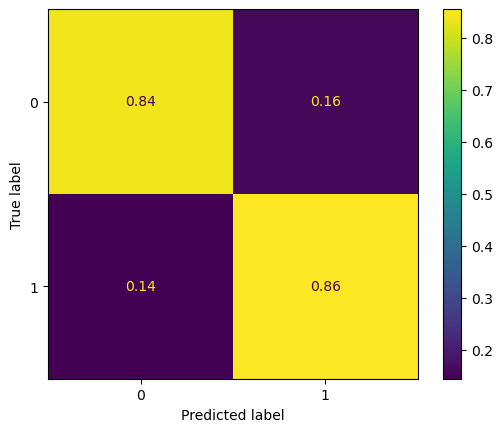

In [19]:
#Visualize
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

cm = confusion_matrix(y_test, y_pred, normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=linReg.classes_)
disp.plot()
plt.show()